# Random Forests

## Laden des Datensatzes "Hauspreise in Iowa"

In [1]:
import pandas as pd
houses = pd.read_csv('hauspreise.csv', index_col='Id')
houses.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Anpassung der Daten

Wir entfernen alle Zeilen, in denen der Preis des Hauses, also unser Target fehlt, und schränken die Daten auf für uns relevante Spalten ein.

In [2]:
houses = houses.dropna(subset=['SalePrice'],axis=0)
features = ['LotArea','OverallQual','OverallCond','YearBuilt','KitchenQual','SalePrice']
houses = houses[features]
houses.head()

,LotArea,OverallQual,OverallCond,YearBuilt,KitchenQual,SalePrice
Id,,,,,,
1,8450,7,5,2003,Gd,208500
2,9600,6,8,1976,TA,181500
3,11250,7,5,2001,Gd,223500
4,9550,7,5,1915,Gd,140000
5,14260,8,5,2000,Gd,250000


## Zerlegung in Trainings- und Testdaten

In [3]:
from sklearn.model_selection import train_test_split

y = houses.SalePrice
X = houses.drop(['SalePrice'], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [4]:
cat_cols = [cname for cname in X_train.columns if X_train[cname].nunique() < 10 and 
                        X_train[cname].dtype == "object"]


num_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int', 'float64']]
cols = cat_cols + num_cols

X_train, X_valid = X_train[cols], X_valid[cols]

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = SimpleImputer(strategy='constant')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

## Pipeline

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

n_estimators = 100
rfr = RandomForestRegressor(n_estimators=n_estimators, random_state=0)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', rfr) ])
pipeline.fit(X_train,y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [7]:
from sklearn.metrics import mean_absolute_error

mea = mean_absolute_error(y_valid, pipeline.predict(X_valid))
print(f'Mean absolute error (sale price):\t{mea:,.0f}')

Mean absolute error (sale price):	25,976


## Verschiedene Größen von RandomForests testen

In [8]:
from sklearn.metrics import mean_absolute_error

def predicts(n_estimators, X_train, y_train, X_valid):
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=0)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', model) ])
    pipeline.fit(X_train, y_train)
    return pipeline.predict(X_valid)

scores = {n_estimators : mean_absolute_error(y_valid, predicts(n_estimators, X_train, y_train, X_valid)) for n_estimators in range(10,200,5) }

Bester Score: 25,684 bei 50 Estimators


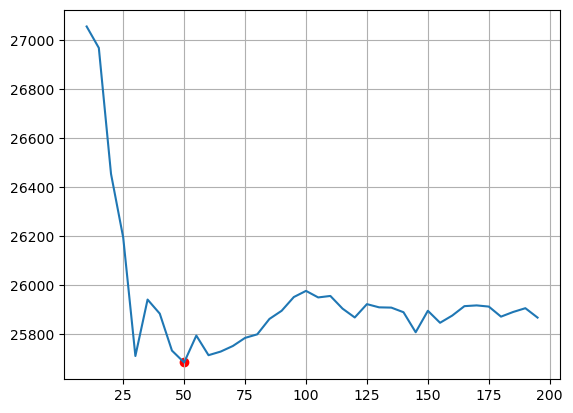

In [9]:
min_est = min(scores, key=scores.get)
min_score = scores.get(min_est)
print(f'Bester Score: {min_score:,.0f} bei {min_est} Estimators')

import matplotlib.pyplot as plt

n_enum, mae = zip(*scores.items())
plt.grid(True)
plt.plot(n_enum, mae);
plt.scatter(min_est,min_score,c='red');